In [2]:
#5-fold cross validation
# Run GBT classifier with cross-validation and plot ROC curves
import numpy as np
import pandas as pd
from functools import reduce

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from itertools import cycle

import matplotlib.pyplot as plt

In [3]:
#load data
#lm = pd.read_csv("/Users/schen/Desktop/scExpression/data/LaManno_1977_cells/allgene_celltype_fraction.csv", index_col=0)
#zhong = pd.read_csv("/Users/schen/Desktop/scExpression/data/Zhong_2018/allgene_celltype_fraction_zhong.csv", index_col=0)
lm = pd.read_csv("/Users/schen/Desktop/scExpression/data/LaManno_1977_cells/celltype>10cells_fraction_LM_noUnk.csv", index_col=0)
zhong = pd.read_csv("/Users/schen/Desktop/scExpression/data/Zhong_2018/celltype>10cells_fraction_zhong.csv", index_col=0)

In [5]:
zhong.shape

(24153, 48)

In [6]:
df_merged = [lm, zhong]
data = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True, how='inner'), df_merged)

In [7]:
data.shape

(17740, 95)

In [8]:
autism_gene = pd.read_csv("/Users/schen/Desktop/scExpression/projects/training/positives/sfari_high_confidence_genes_08292019.csv", index_col=0)
control_gene = pd.read_csv("/Users/schen/Desktop/scExpression/projects/training/negatives/control_genes_1911_iossifov.csv", index_col=0)

In [9]:
autism = data.loc[data.index.intersection(autism_gene['gene.symbol']),]
autism.shape

(88, 95)

In [10]:
control = data.loc[data.index.intersection(control_gene['GeneName']), ]
control.shape

(156, 95)

In [11]:
autism.index.intersection(control.index)

Index([u'KDM5B', u'CACNA1H'], dtype='object')

In [12]:
control = control.drop(['CACNA1H', ])
control = control.drop(['KDM5B', ])
control.shape

(154, 95)

In [13]:
combine = [autism, control]
combine = pd.concat(combine)
combine.shape

(242, 95)

In [14]:
prelabel = np.array([1,0])
label = pd.DataFrame({'labels': np.repeat(prelabel, [autism.shape[0], control.shape[0]], axis = 0)})
label.shape

(242, 1)

In [15]:
index = np.random.permutation(label.index)
combine = combine.iloc[index]
label = label.iloc[index]

/Users/schen/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/schen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


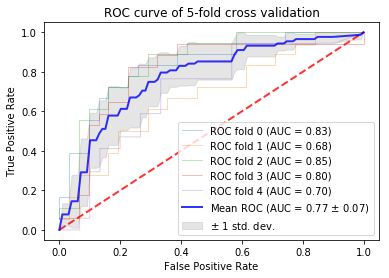

In [16]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
pre_df = pd.DataFrame(index = data.index)
oddsratio_df = pd.DataFrame(index = np.arange(0.0,1.05,0.05))
fi_df = pd.DataFrame()
for train, test in cv.split(combine, label):
    params = {'n_estimators': 300,'learning_rate': 0.05, 'max_depth':1, 'random_state':2019}
    clf = GradientBoostingClassifier(**params).fit(combine.iloc[train], label.iloc[train])
    #print(combine.ix[test])
    
    probas_ = clf.predict_proba(combine.iloc[test])
    #print probas_
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(label.iloc[test], probas_[:,[1]])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #calculate odds ratio
    ortable = label.iloc[test]
    ortable['probas_'] = probas_[:,[1]]
    oddsratios = []
    for j in np.arange(0.0,1.05,0.05):
        upthreshold = ortable[ortable['probas_'] >= j]
        x1 = float(sum(upthreshold['labels'] == 1)+1)
        x0 = float(sum(upthreshold['labels'] == 0)+1)
        
        downthreshold = ortable[ortable['probas_'] < j]
        y1 = float(sum(downthreshold['labels'] == 1)+1)
        y0 = float(sum(downthreshold['labels'] == 0)+1)
        
        oddsratio = (x1/y1)/(x0/y0)
        oddsratios.append(oddsratio)
    oddsratio_df.insert(value = oddsratios, column = i, loc = 0)
    
    prediction = clf.predict_proba(data)
    pre_df.insert(value= prediction[:,[1]], column= i, loc=0)
    
    fi = clf.feature_importances_
    fi_df.insert(value= fi, column = i, loc = 0)

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of 5-fold cross validation')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('../plot/ROC_filteredCellNumber_LMZhong_fracE_classifier_average_08292019sfari.pdf', bbox_inches = 'tight')

In [21]:
#plot feature importance that are not zero
feature_importance = fi_df.mean(axis=1)
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array
sorted_idx = sorted_idx[np.array(feature_importance[sorted_idx] != 0)]

In [22]:
sorted_idx.shape

(66,)

In [23]:
pos = np.arange(0,sorted_idx.shape[0]*3, 3) + .5
pos.shape

(66,)

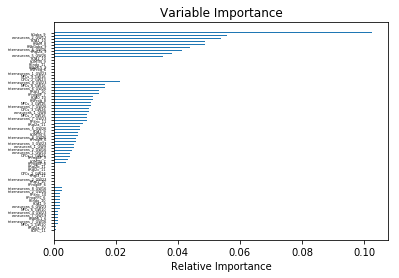

In [24]:
plt.tick_params(axis = "y", labelsize = 3.5)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, combine.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
#plt.savefig('/Users/schen/Desktop/scExpression/projects/GBT/plot/feature_importance_filteredCellNumber_LMZhong_fracE_classifier_average_noUnk_08292019sfari.pdf', bbox_inches = 'tight')

In [25]:
feature_importance_sele = pd.DataFrame({'celltypes': combine.columns[sorted_idx], 'importance': feature_importance[sorted_idx]})
feature_importance_sele

,celltypes,importance
30,hOPC_11,0.000667
14,hRgl2a_10,0.000667
77,NPCs_1_GW10,0.001333
87,interneurons_7_GW16,0.001333
37,hNbML1_6,0.001333
58,exneurons_7_GW19,0.001333
50,interneurons_4_GW23,0.001333
76,NPCs_6_GW10,0.002000
47,exneurons_6_GW23,0.002000
10,hDA1_9,0.002000


In [26]:
feature_importance_sele.to_csv('../data/feature_importance_filteredCellNumber_LMZhong_fracE_filtergene_zhong_classifier_average_noUnk_08292019sfari.csv')

In [23]:
pre_prob = pd.DataFrame(pre_df.mean(axis=1))

pre_prob['Batch'] = 'testing'
pre_prob.loc[autism.index,'Batch'] = 'autism'
pre_prob.loc[control.index,'Batch'] = 'control'

pre_prob.rename(columns={0 : 'Frisk'}, inplace=True)
pre_prob

,Frisk,Batch
DDX11L1,0.079844,testing
LOC101928626,0.131699,testing
LINC00115,0.106165,testing
LINC01128,0.205489,testing
FAM41C,0.131445,testing
SAMD11,0.073027,testing
NOC2L,0.239372,testing
KLHL17,0.134382,testing
PLEKHN1,0.057149,testing
PERM1,0.053627,testing


In [24]:
pre_prob.to_csv('../data/prediction_allGenes_GBT_filteredCellNumber_LMZhong_fracE_classifier_average_noUnk_08292019sfari.csv')

In [35]:
#or_crossvalidation = pd.DataFrame(oddsratio_df.mean(axis=1))
#or_crossvalidation.rename(columns={0:'Odds ratio'}, inplace=True)
#or_crossvalidation.to_csv('../data/oddsRatio_corssValidation.csv')

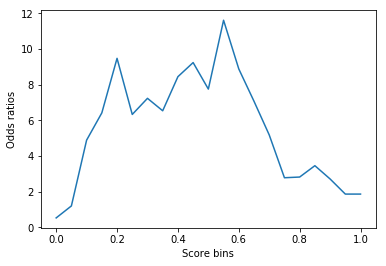

In [39]:
#plt.plot(or_crossvalidation)
#plt.xlabel('Score bins')
#plt.ylabel('Odds ratios')
#plt.savefig('../plot/or_crossvalidation.pdf', bbox_inches = 'tight')